# Summary 

Data: 1782 related timeseries 
   - sales data for 33 product categories (family) in 54 stores: each category is one time series
   - each series has 1684 daily observations: 01/2013 - 08/2017
   - total: 1782 * 1684 = 3,000,888 obs

**Forecasting problem: predict sales for each family in each store for the next 14 days**

Family-level hierachy
   - 33 categories: total sales in all stores
   - 54 stores for each family

Use **Darts** for Time Series Forecasting
- Local models: Exponential Smoothing
   - one model for each time series: 1782 models
- Global models: LGBM
   - one model for each family: 33 models

## Additional Data

Stores
- Cities: 22, main one is Quito
- States: 12, main one is Pichincha
- Types: A, B, C, D, E
- Cluster

Holidays
- national holidays
- regional holidays
- events: football


# 1.Libraries

In [1]:
## Install libraries

# %pip install pyyaml -U
# %pip install "u8darts[all]"
# %pip install optuna -U


In [2]:
import torch
print(torch.__version__)

# M1: check metal GPU
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

import darts
print(darts.__version__)





2.2.0
True
True
0.27.2


In [3]:
import numpy as np
import time
from pathlib import Path
import sklearn


from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import LightGBMModel, ExponentialSmoothing
from darts.metrics import mape, smape, rmse, rmsle
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.missing_values import fill_missing_values
from darts.models.filtering.moving_average_filter import MovingAverageFilter 
# import MovingAverage deprecated


import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm import tqdm

from sklearn import preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import gc

%matplotlib inline
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

/opt/anaconda3/envs/Darts_metal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/Darts_metal/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


# 2.Pre-Processing

In [4]:
%%script echo skipping

# # Kaggle data folder

# # Load all Datasets
# df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
# df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
# df_holidays_events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
# df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
# df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
# df_transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
# df_sample_submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')


skipping


In [5]:
# Local data folder

# local data path using pathlib
basepath = Path.cwd()
datapath = basepath.parent / 'data'

# raw data path
raw_datapath = datapath / 'raw'

# clearn data path
clean_datapath = datapath / 'clean'

print(raw_datapath)
print(clean_datapath)

# Load all Datasets
df_train = pd.read_csv(raw_datapath/'train.csv')
df_test = pd.read_csv(raw_datapath/'test.csv')
df_holidays_events = pd.read_csv(raw_datapath/'holidays_events.csv')
df_oil = pd.read_csv(raw_datapath/'oil.csv')
df_stores = pd.read_csv(raw_datapath/'stores.csv')
df_transactions = pd.read_csv(raw_datapath/'transactions.csv')
df_sample_submission = pd.read_csv(raw_datapath/'sample_submission.csv')


/Users/mbp14/Desktop/GoogleDrive/Kaggle/Store_sales_favorita/data/raw
/Users/mbp14/Desktop/GoogleDrive/Kaggle/Store_sales_favorita/data/clean


In [6]:
# Sales Data (Target)

family_list = df_train['family'].unique()
family_list

store_list = df_stores['store_nbr'].unique()
store_list

# merge stores and items data: add store features as columns
train_merged = pd.merge(df_train, df_stores, on ='store_nbr')
train_merged = train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

# sort to inspect
train_merged = train_merged.sort_values(["store_nbr","family","date"])
df_test_sorted = df_test.sort_values(by=['store_nbr','family'])


In [7]:
## Clustered by Product Family: create TimeSeries objects and arrange in a Dictionary

family_TS_dict = {}

for family in family_list:
  
  # filter by family product
  df_family = train_merged.loc[train_merged['family'] == family]

  # extract individual time series and static covariates given family
  list_of_TS_family = TimeSeries.from_group_dataframe(
                      df_family,
                      time_col="date",
                      group_cols=["store_nbr","family"],  # individual time series: extract from vertical stacking (stores, family changing)
                      static_cols=["city","state","type","cluster"], # static covariates: store features -> same value for all series in the group
                      value_cols="sales", # target variable
                      fill_missing_dates=True,
                      freq='D')
  
  # downcast to float32
  for ts in list_of_TS_family:
    ts = ts.astype(np.float32)

  # for each product family, store time series in a list sorted by store_nbr
  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  # store a list of 54 timeseries for each family
  family_TS_dict[family] = list_of_TS_family


In [8]:
# the dictionary contains 33 keys (product families)
# each key points to a list of 54 timeseries (one for each store)
# each timeseries has 5 static covariates (store features) beside family

# _df = family_TS_dict['DELI'][0].pd_dataframe()
# _df.tail()

## Transform sales data


In [9]:
# Transform the Sales Data
family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  
  # specify transformers for each family
  train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  # build pipeline
  train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
  
  # fit the pipeline and transform the data
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  
  # save the trained pipeline in a dictionary
  family_pipeline_dict[key] = train_pipeline
  
  # save the transformed data in a dictionary
  family_TS_transformed_dict[key] = training_transformed


In [10]:
# Create 7-day and 28-day moving average of sales
sales_moving_average_7 = MovingAverageFilter(window=7)
sales_moving_average_28 = MovingAverageFilter(window=28)

sales_moving_averages_dict = {}

for key in family_TS_transformed_dict:
  sales_mas_family = []
  
  for ts in family_TS_transformed_dict[key]:
    # apply MA filter 7 days, cast to float32 and rename columns
    ma_7 = sales_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="sales_ma_7")
    # apply MA filter 28 days, cast to float32 and rename columns
    ma_28 = sales_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="sales_ma_28")
    
    # stack the two moving averages side by side: multivariate series of MAs
    mas = ma_7.stack(ma_28)
    
    # append to the list: 54 series for each family
    sales_mas_family.append(mas)
  
  # save the list to the dictionary
  sales_moving_averages_dict[key] = sales_mas_family  
  

## Time covariates

In [11]:
# create time effect as static covariates
# time covariates are global for all families series: one multi-variate series

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')

# Time-Based Covariates
year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

# Transform
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)



## Oil Price Covariate

In [12]:
# Oil Price
oil = TimeSeries.from_dataframe(df_oil, 
                                time_col = 'date', 
                                value_cols = ['dcoilwtico'],
                                freq = 'D')

oil = oil.astype(np.float32)

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_28 = MovingAverageFilter(window=28)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)


# general covariates are shared for all families series: one multi-variate series
# 7 time covariates + 3 oil covariates

## Store-specific covariates: Transactions and Holidays

In [13]:
# Holidays and Events

# Re-Defining Categories of Holidays: holidays -> true holidays (day off)
df_holidays_events['type'] = np.where(df_holidays_events['transferred'] == True,'Transferred', df_holidays_events['type'])
df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Transfer','Holiday', df_holidays_events['type'])
df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Additional','Holiday', df_holidays_events['type'])
df_holidays_events['type'] = np.where(df_holidays_events['type'] == 'Bridge','Holiday', df_holidays_events['type'])


# Get holidays dummies for each store

def holiday_list(df_stores):

    listofseries = []
    
    for i in range(0,len(df_stores)):
        
            df_holiday_dummies = pd.DataFrame(columns=['date'])
            df_holiday_dummies["date"] = df_holidays_events["date"]
            df_holiday_dummies["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & (df_holidays_events["locale"] == "National")), 1, 0)
            df_holiday_dummies["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)
            df_holiday_dummies["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)
            df_holiday_dummies["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)
            df_holiday_dummies["national_event"] = np.where(((df_holidays_events["type"] == "Event") & (df_holidays_events["locale"] == "National") & (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & (~df_holidays_events['description'].str.contains('futbol'))), 1, 0)
            df_holiday_dummies["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)

            # local holidays are specific to one of the stores
            mask = (df_holidays_events["type"] == "Holiday") & ((df_holidays_events["locale_name"] == df_stores['state'][i]) | (df_holidays_events["locale_name"] == df_stores['city'][i]))
            df_holiday_dummies["local_holiday"] = np.where(mask, 1, 0)
                     
            listofseries.append(df_holiday_dummies)

    return listofseries


# list_of_holidays_per_store = holiday_list(df_stores)

def remove_0_and_duplicates(holiday_list):

    listofseries = []
    
    for i in range(0,len(holiday_list)):
            
            df_holiday_per_store = list_of_holidays_per_store[i].set_index('date')

            df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]
            
            df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                                   'christmas':'max', 'football_event':'max', 
                                   'national_event':'max', 'work_day':'max', 
                                   'local_holiday':'max'}).reset_index()

            listofseries.append(df_holiday_per_store)

    return listofseries

# convert holidays df to list to time series 
def holiday_TS_list_54(holiday_list):

    listofseries = []
    
    for i in range(0,54):
            
            holidays_TS = TimeSeries.from_dataframe(list_of_holidays_per_store[i], 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
            holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
            holidays_TS = holidays_TS.astype(np.float32)
            listofseries.append(holidays_TS)

    return listofseries



list_of_holidays_per_store = holiday_list(df_stores)
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)   
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

# each store has a time series of holidays and events
# multi-variate series of 7 columns: national_holiday, earthquake_relief, christmas, football_event, national_event, work_day, local_holiday

In [14]:
from datetime import datetime, timedelta

# Transactions
df_transactions.sort_values(["store_nbr","date"], inplace=True)

# extract transactions time series for each store
TS_transactions_list = TimeSeries.from_group_dataframe(
                                df_transactions,
                                time_col="date",
                                group_cols=["store_nbr"],  # individual time series are extracted by grouping `df` by `group_cols`
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())   # necessary workaround to remove static covariates
            series = series.astype(np.float32)
            transactions_list.append(series)

# missing dates: span full date range 
transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

transactions_list_full = []

for ts in transactions_list:
  if ts.start_time() > pd.Timestamp('20130101'):
    end_time = (ts.start_time() - timedelta(days=1))
    delta = end_time - pd.Timestamp('20130101')
    zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'), 
                              end=end_time, freq="D"),
                              values=np.zeros(delta.days+1))
    ts = zero_series.append(ts)
    transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

# Moving Averages for Transactions
trans_moving_average_7 = MovingAverageFilter(window=7)
trans_moving_average_28 = MovingAverageFilter(window=28)

transactions_covs = []

for ts in transactions_transformed:
  ma_7 = trans_moving_average_7.filter(ts).astype(np.float32)
  ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="transactions_ma_7")
  ma_28 = trans_moving_average_28.filter(ts).astype(np.float32)
  ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="transactions_ma_28")
  trans_and_mas = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions").stack(ma_7).stack(ma_28)
  transactions_covs.append(trans_and_mas)

# each store has a time series of transactions
# 3 components: transactions, 7-day MA, 28-day MA

## Store-family covariates: Promotion

In [15]:
# get promotion data: we know promotion in test set, use at prediction time
df_promotion = pd.concat([df_train, df_test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
df_promotion.tail()


# extract promotion time series for each family, in each store
family_promotion_dict = {}

for family in family_list:
  df_family = df_promotion.loc[df_promotion['family'] == family]

  list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],  # individual time series are extracted by grouping `df` by `group_cols`
                                value_cols="onpromotion", # covariate of interest
                                fill_missing_dates=True,
                                freq='D')
  
  for ts in list_of_TS_promo:
            ts = ts.astype(np.float32)

  family_promotion_dict[family] = list_of_TS_promo

# tranform data and apply moving averages
promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
  promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  promo_pipeline = Pipeline([promo_filler,
                             promo_scaler])
  
  promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

  # Moving Averages for Promotion Family Dictionaries
  promo_moving_average_7 = MovingAverageFilter(window=7)
  promo_moving_average_28 = MovingAverageFilter(window=28)

  promotion_covs = []

  for ts in promotion_transformed:
    ma_7 = promo_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
    ma_28 = promo_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
    promo_and_mas = ts.stack(ma_7).stack(ma_28)
    promotion_covs.append(promo_and_mas)

  promotion_transformed_dict[key] = promotion_covs


100%|██████████| 33/33 [00:15<00:00,  2.16it/s]


## Stack all the covariates together

In [16]:
# stack global covariates
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

# for each store, stack store-specific holidays
store_covariates_future = []

for store in range(0,len(store_list)):
  stacked_covariates = holidays_transformed[store].stack(general_covariates)
  store_covariates_future.append(stacked_covariates)
  

# future covariates are external features known at prediction time
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):
  promotion_family = promotion_transformed_dict[key]
  covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]
  future_covariates_dict[key] = covariates_future
  

# past covariates: at time t unknown to the model (e.g. total transactions)
only_past_covariates_dict = {}

for key in tqdm(sales_moving_averages_dict):
  sales_moving_averages = sales_moving_averages_dict[key]
  only_past_covariates = [sales_moving_averages[i].stack(transactions_covs[i]) for i in range(0,len(sales_moving_averages))]

  only_past_covariates_dict[key] = only_past_covariates


# Delete df to save memory
del(df_train)
del(df_test)
del(df_stores)
del(df_holidays_events)
del(df_oil)
del(df_transactions)
gc.collect()



100%|██████████| 33/33 [00:00<00:00, 36.41it/s]


132

# 3.EDA: main takeaways

Zero sales in training by store and family:
- some stores don't sell certain product families, always zero
- stores may start/stop selling product families

Should add zero forecast based on past month (week)?

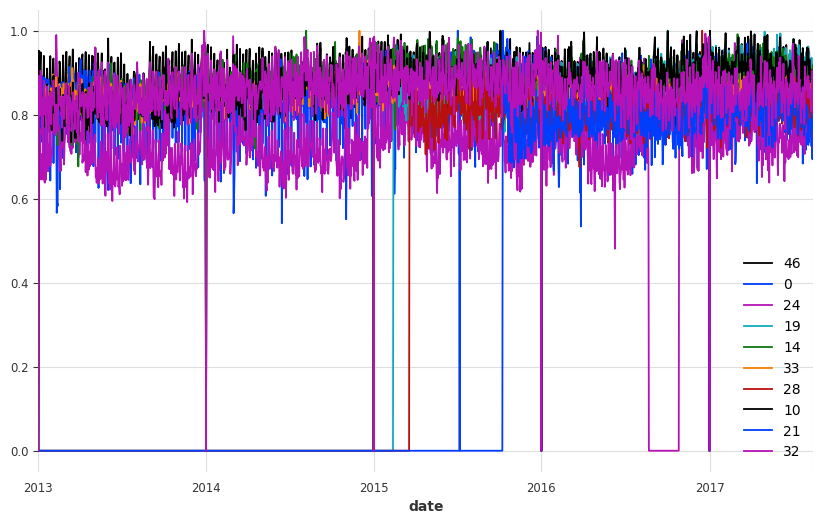

In [64]:
# Get one family to test the model
family = 'DELI'

# get the time series for the family
family_series = family_TS_transformed_dict[family]

# convert ts to df and stack in a dictionary
plot_series = {}

for idx,ts in enumerate(family_series):
  # stack to a df
  df = ts.pd_dataframe()
  plot_series[idx] = df
  
#make a new dataframe from the dictionary
df_ = pd.concat(plot_series, axis=1)
df_ = df_.droplevel(level=1, axis=1) # drop component level 

# slice 10 random series to plot
df_.sample(10, axis=1).plot(figsize=(10, 6));

# store 21 started selling after 2.5y
# store 51 started selling after 4y
# store 32 stopped selling for 1 month?


# 4.Models

## Single TS Models
- fit one model per time series: 1782 models

In [18]:
# Functions for Exponential Smoothing Models and Forecasts

def ESModelBuilder(training_list):

    listofESmodels = []

    for i in range(0,len(training_list)):
        ES_model = ExponentialSmoothing()
        ES_model.fit(training_list[i])
        listofESmodels.append(ES_model)

    return listofESmodels 

def ESForecaster(model_list):

    listofESpreds = []

    for i in range(0,len(model_list)):
        pred_ES = model_list[i].predict(n=16)
        listofESpreds.append(pred_ES)        

    return listofESpreds 

# Train and Forecast with Exponential Smoothing Models

ES_Models_Family_Dict = {}
ES_Forecasts_Family_Dict = {}

# get the start time
st = time.time()

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family] # extract a list of 54 ts for each family
  training_data = [ts[:-16] for ts in sales_family] # each ts is sliced to train the model

  ES_Models_Family_Dict[family] = ESModelBuilder(training_data)
  forecasts_ES = ESForecaster(ES_Models_Family_Dict[family])
    
  # Transform Back
  ES_Forecasts_Family_Dict[family] = family_pipeline_dict[family].inverse_transform(forecasts_ES, partial=True)

  # Zero Forecasting
  for i in range(0,len(ES_Forecasts_Family_Dict[family])):
      if (training_data[i].univariate_values()[-14:] == 0).all(): # if the last 14 days are zero, predict zero
          ES_Forecasts_Family_Dict[family][i] = ES_Forecasts_Family_Dict[family][i].map(lambda x: x * 0)

# get the end time
et = time.time()

# get the execution time
elapsed_time_exp = et - st
    

100%|██████████| 33/33 [06:37<00:00, 12.04s/it]


In [19]:
# Re-Format Forecasts from Dictionaries to One List

# forecasts for each family: has been transformed back to actual values 
forecast_list_ES = []

for family in family_list:
  forecast_list_ES.append(ES_Forecasts_Family_Dict[family])

# actual sales data: use data before transform
sales_data = []

for family in family_list:
  sales_data.append(family_TS_dict[family]) # do not use transformed data

# Function to Flatten Nested Lists
def flatten(l):
  return [item for sublist in l for item in sublist]
    
actual_list = flatten(sales_data)
pred_list_ES = flatten(forecast_list_ES)

# Mean RMSLE
ES_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_ES,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print(f'The mean RMSLE over 1782 series is {ES_rmsle:.5f}')
print(f'Training & Inference duration: {elapsed_time_exp/60} minutes')


# RMSLE : RMSE Log Error
# larger penalty for Underestimation of the target than Overestimation.

The mean RMSLE over 1782 series is 0.37412
Training & Inference duration: 6.6245390971501665 minutes


## Global models: multiple time series with static covariates
Fit one model for each family: 33 models
  - add future covariates: time, oil price, holidays, promotion
  - add past covariates: transactions, sales MAs

Need Torch 2.0.1 for Apple GPU support
- Jupyter kernel crashes otherwise

## Testing LGBM Model

In [20]:
# train models for each family

LGBM_Models = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16]  for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  # make sure training data and covariates have the same time index
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  # initialize and fit the model
  LGBM_Model = LightGBMModel(lags = 63,
                            lags_future_covariates = (7,1),
                            lags_past_covariates = [-16,-17,-18,-19,-20,-21,-22], # skipping 2 weeks (last day of test period: unknown past covariates)
                            output_chunk_length=1,
                            random_state=2022,
                            gpu_use_dp= "true",
                            )
     
  LGBM_Model.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed)

  # save model to dict
  LGBM_Models[family] = LGBM_Model
  
# actually much faster than local models
  

  0%|          | 0/33 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31686
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.460316


  3%|▎         | 1/33 [00:02<01:06,  2.08s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18019
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.026299


  6%|▌         | 2/33 [00:03<00:48,  1.57s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31575
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.353760


  9%|▉         | 3/33 [00:05<00:50,  1.68s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35374
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.771974


 12%|█▏        | 4/33 [00:07<00:53,  1.85s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18355
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 320
[LightGBM] [Info] Start training from score 0.014890


 15%|█▌        | 5/33 [00:08<00:43,  1.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35358
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.779958


 18%|█▊        | 6/33 [00:10<00:46,  1.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33110
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.312484


 21%|██        | 7/33 [00:11<00:44,  1.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35374
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.775875


 24%|██▍       | 8/33 [00:13<00:45,  1.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35374
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.787609


 27%|██▋       | 9/33 [00:15<00:45,  1.88s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35366
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.783017


 30%|███       | 10/33 [00:18<00:44,  1.92s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34758
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.724749


 33%|███▎      | 11/33 [00:19<00:42,  1.94s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34870
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.524890


 36%|███▋      | 12/33 [00:22<00:41,  1.98s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35374
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.780776


 39%|███▉      | 13/33 [00:24<00:39,  1.99s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30779
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.475137


 42%|████▏     | 14/33 [00:25<00:36,  1.95s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24370
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.213317


 45%|████▌     | 15/33 [00:27<00:33,  1.86s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34846
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.366288


 48%|████▊     | 16/33 [00:29<00:31,  1.84s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33646
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.367701


 52%|█████▏    | 17/33 [00:31<00:29,  1.82s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17200
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.130592


 55%|█████▍    | 18/33 [00:32<00:25,  1.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35094
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.501063


 58%|█████▊    | 19/33 [00:34<00:24,  1.73s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31272
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.254436


 61%|██████    | 20/33 [00:35<00:21,  1.66s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30734
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.216029


 64%|██████▎   | 21/33 [00:37<00:20,  1.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30882
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.399211


 67%|██████▋   | 22/33 [00:39<00:19,  1.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33998
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.493900


 70%|██████▉   | 23/33 [00:41<00:18,  1.81s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29743
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.226682


 73%|███████▎  | 24/33 [00:43<00:15,  1.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35083
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.758737


 76%|███████▌  | 25/33 [00:45<00:14,  1.83s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35310
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.720511


 79%|███████▉  | 26/33 [00:47<00:13,  1.89s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30527
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.264802


 82%|████████▏ | 27/33 [00:48<00:10,  1.81s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31606
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.313998


 85%|████████▍ | 28/33 [00:50<00:08,  1.77s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35222
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.731267


 88%|████████▊ | 29/33 [00:52<00:07,  1.82s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33254
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.729165


 91%|█████████ | 30/33 [00:54<00:05,  1.85s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35374
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.558112


 94%|█████████▍| 31/33 [00:56<00:03,  1.82s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32843
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.086103


 97%|█████████▋| 32/33 [00:57<00:01,  1.73s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31614
[LightGBM] [Info] Number of data points in the train set: 86886, number of used features: 344
[LightGBM] [Info] Start training from score 0.511644


100%|██████████| 33/33 [00:59<00:00,  1.80s/it]


In [21]:
# forecast with LGBM models in evaluation set

LGBM_Forecasts = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts[:-16]  for ts in sales_family] 
  LGBM_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  # make forecasts
  forecast_LGBM = LGBM_Models[family].predict(n=16,
                                         series=train_sliced,
                                         future_covariates=LGBM_covariates,
                                         past_covariates=transactions_transformed)
  
  # Transform Back
  LGBM_Forecasts[family] = family_pipeline_dict[family].inverse_transform(forecast_LGBM, partial=True)

  # Zero Forecasting
  for i in range(0,len(LGBM_Forecasts[family])):
      if (training_data[i].univariate_values()[-14:] == 0).all():
          LGBM_Forecasts[family][i] = LGBM_Forecasts[family][i].map(lambda x: x * 0)
  
  
  LGBM_Forecasts[family] = forecast_LGBM

100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


In [23]:
# Re-Format Forecasts from Dictionaries to One List

forecast_list_LGBM = []

for family in family_list:
  forecast_list_LGBM.append(LGBM_Forecasts[family]) # append forecast lists to the big list

sales_data = []

for family in family_list:
  sales_data.append(family_TS_dict[family])

# Function to Flatten Nested Lists
def flatten(l):
  return [item for sublist in l for item in sublist]
    
actual_list = flatten(sales_data)
pred_list_lgbm = flatten(forecast_list_LGBM)

# Mean RMSLE
lgbm_rmsle = rmsle(actual_series = actual_list,
                 pred_series = pred_list_lgbm,
                 n_jobs = -1,
                 inter_reduction=np.mean)

print(f'The mean RMSLE is {lgbm_rmsle:.5f}')


The mean RMSLE is 3.25308


Possible issues
- normalization of errors
- zeros errors forecasts rework
- covariates didn't work correctly
- store level: models failed to capture peak sales
